In [ ]:
!pip install optunity

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC,SVR
from sklearn import datasets
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
# from imblearn.over_sampling import SMOTE
from collections import Counter
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

seed = 7
np.random.seed(seed)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path='/content/drive/MyDrive/Major Project/New/mangalath-failure modes/Shear-Wall-Failure-Mode-master/Shear_Wall_Database.xlsx'
def dataprocessor(path):
  data1=pd.read_excel(path,sheet_name='Database')
  data=data1.loc[:, 'FailureMode':'Ab/Ag']
  data_mod_lc = data.copy()
  data_mod_lc['Section'] = data_mod_lc['Section'].astype('category')
  #print(cat_bird_lc.dtypes)
  data_mod_lc['Section'] = data_mod_lc['Section'].cat.codes
  data['Section'] = data_mod_lc['Section']
  data = pd.get_dummies(data = data , columns=['Section'] )
  X = data.loc[:, data.columns != 'FailureMode']
  y=data['FailureMode']-1
  return X,y
X,y=dataprocessor(path)
print(X.shape,y.shape)

(393, 11) (393,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape,X_test.shape)

(275, 11) (118, 11)


In [ ]:
print("Train \n",Counter(y_train))
print("Test \n",Counter(y_test))

Train 
 Counter({0.0: 106, 2.0: 84, 1.0: 66, 3.0: 19})
Test 
 Counter({0.0: 46, 2.0: 38, 1.0: 30, 3.0: 4})


In [ ]:
def balance(X_train,y_train):
  print("Before: ",Counter(y_train))
  smote=SMOTE()
  X_train_smote,y_train_smote=smote.fit_resample(X_train.astype('float'),y_train)
  print("After: ",Counter(y_train_smote))
  
  return X_train_smote,y_train_smote

In [ ]:
# x_new,y_new=balance(X_train,y_train)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input,Dropout
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import randint as sp_randint

In [ ]:
def plot_metrics(history):
    print(history.history.keys())
    plt.figure()
    plt.title('model accuracy')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    return

In [ ]:
def evaluate_model(model,ytrue,ypred):
  cf_matrix=confusion_matrix(ytrue, ypred)
  plt.figure()
  sns.heatmap(cf_matrix, annot=True, 
             cmap='Blues')
  plt.show()
  return

In [ ]:
def create_model(optimizer = 'adam',num_of_hl=2,batch_size=16,dropout=0.2,neurons=72,activation='relu'):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(11,), activation=activation))
    for i in range(num_of_hl):
      model.add(Dense(neurons, activation=activation))
      model.add(Dropout(dropout))
    model.add(Dense(4,activation='softmax'))  # 10 is the number of classes in the dataset, you can change it based on your dataset
    model.compile(optimizer = optimizer, loss='categorical_crossentropy',metrics=["accuracy"])
    print(model.summary())
    history=model.fit(X_train, pd.get_dummies(y_train).values,
                      validation_data=(X_test,pd.get_dummies(y_test)),
              batch_size=batch_size,
              epochs=120,
              verbose=0)
    
    plot_metrics(history)
    print(model.evaluate(X_test,pd.get_dummies(y_test)))
    ypred=np.argmax(model.predict(X_test),axis=1)
    # print(ypred)
    evaluate_model(model,y_test,ypred)
    return model

In [ ]:
import optunity
import optunity.metrics


data=X.values
labels=y.values.tolist()


search = {
    'optimizer':[0,3],
    'activation':[0,2],
    'batch_size': [0, 2],
    'neurons': [10, 100],
    'num_of_hl':[1,3],
    'dropout':[0,2]
         }
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,dropout=None,optimizer=None,activation=None,batch_size=None,num_of_hl=None,neurons=None):
    # fit the model
    if optimizer<1:
        op='adam'
    elif optimizer<2:
        op='sgd'
    else:
        op='rmsprop'
    if activation<1:
        ac='relu'
    else:
        ac='tanh'
    if batch_size<1:
        ba=16
    else:
        ba=32
    if dropout<1:
      do=0.1
    else:
      do=0.2

    model = create_model(
                optimizer=op,
                num_of_hl=int(num_of_hl),
                activation=ac,
                batch_size=ba,
                neurons=int(neurons),
                dropout=do
                )
    clf = KerasClassifier(build_fn=create_model, verbose=0)
    scores=np.mean(cross_val_score(clf, X, y, cv=3, 
                                    scoring="accuracy"))

    return scores

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
print(optimal_configuration)
print("MSE:"+ str(info.optimum))

Output hidden; open in https://colab.research.google.com to view.

Model: "sequential_236"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_918 (Dense)           (None, 72)                864       
                                                                 
 dense_919 (Dense)           (None, 72)                5256      
                                                                 
 dropout_446 (Dropout)       (None, 72)                0         
                                                                 
 dense_920 (Dense)           (None, 72)                5256      
                                                                 
 dropout_447 (Dropout)       (None, 72)                0         
                                                                 
 dense_921 (Dense)           (None, 4)                 292       
                                                                 
Total params: 11,668
Trainable params: 11,668
Non-tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


None
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


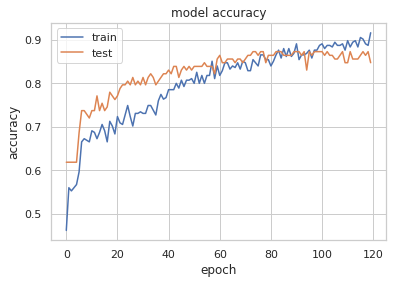

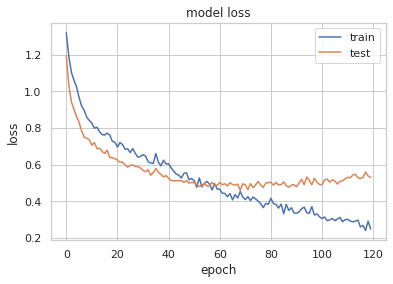

4/4 [==============================] - 0s 3ms/step - loss: 0.5296 - accuracy: 0.8475
[0.5295637249946594, 0.8474576473236084]


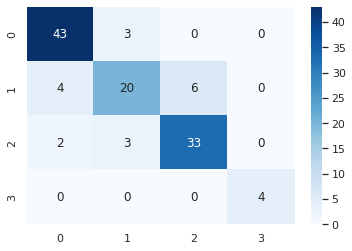

Model: "sequential_237"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_922 (Dense)           (None, 72)                864       
                                                                 
 dense_923 (Dense)           (None, 72)                5256      
                                                                 
 dropout_448 (Dropout)       (None, 72)                0         
                                                                 
 dense_924 (Dense)           (None, 72)                5256      
                                                                 
 dropout_449 (Dropout)       (None, 72)                0         
                                                                 
 dense_925 (Dense)           (None, 4)                 292       
                                                                 
Total params: 11,668
Trainable params: 11,668
Non-tr

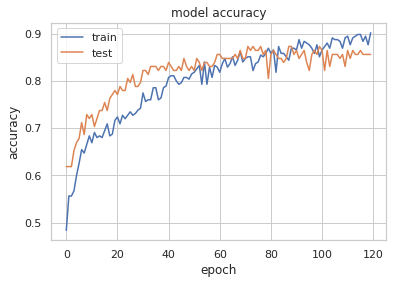

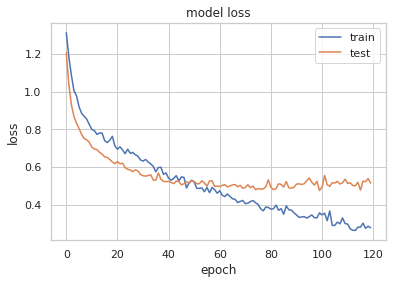

4/4 [==============================] - 0s 3ms/step - loss: 0.5137 - accuracy: 0.8559
[0.5136885046958923, 0.8559321761131287]


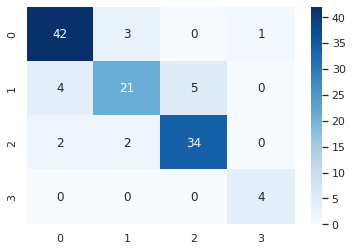

Model: "sequential_238"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_926 (Dense)           (None, 72)                864       
                                                                 
 dense_927 (Dense)           (None, 72)                5256      
                                                                 
 dropout_450 (Dropout)       (None, 72)                0         
                                                                 
 dense_928 (Dense)           (None, 72)                5256      
                                                                 
 dropout_451 (Dropout)       (None, 72)                0         
                                                                 
 dense_929 (Dense)           (None, 4)                 292       
                                                                 
Total params: 11,668
Trainable params: 11,668
Non-tr

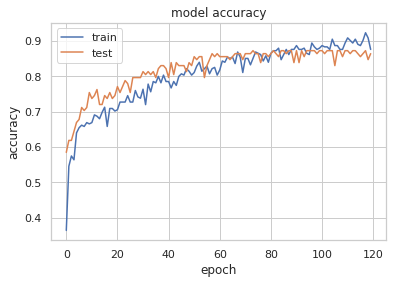

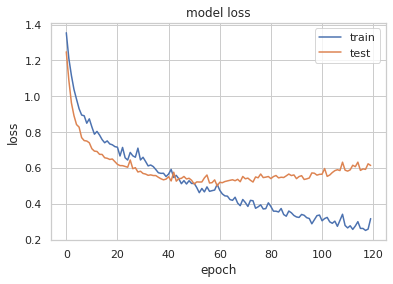

4/4 [==============================] - 0s 3ms/step - loss: 0.6148 - accuracy: 0.8644
[0.6147921085357666, 0.8644067645072937]


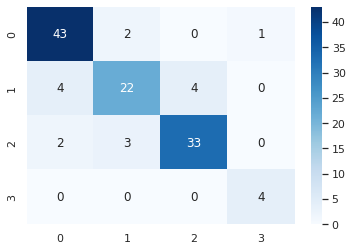

[0.94565217 0.88043478 0.89010989]
Accuracy:0.9053989488772097


In [ ]:
clf = KerasClassifier(build_fn=create_model, verbose=0)
scores = cross_val_score(clf, X_train, y_train, cv=3,scoring='accuracy')
print(scores)
print("Accuracy:"+ str(scores.mean()))